In [17]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [18]:
data = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')

In [19]:
#Create a new column as Total Income

data['TotalIncome']= data['ApplicantIncome']+data['CoapplicantIncome']
data_val['TotalIncome']=data_val['ApplicantIncome']+data_val['CoapplicantIncome']
#Take a log of TotalIncome + 1, adding 1 to deal with zeros of TotalIncome it it exists
data['Log_TotalIncome']=np.log(data['TotalIncome'])
data_val['Log_TotalIncome']=np.log(data_val['TotalIncome'])

In [20]:
print('Number of Loan Id labels: ', len(data.Loan_ID.unique()))
print('Number of Loan in the Dataset: ', len(data))

for df in data, data_val:
    df['Dependents'] = np.where(df['Dependents'] == '3+','3',df['Dependents'])
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    
data.Dependents.fillna(data.Dependents.mode()[0], inplace=True)
data_val.Dependents.fillna(data_val.Dependents.mode()[0], inplace=True)

Number of Loan Id labels:  614
Number of Loan in the Dataset:  614


In [21]:
for df in data, data_val:
    data.Property_Area.value_counts().sort_values(ascending=False)
    location = [x for x in df.Property_Area.value_counts().sort_values(ascending=False).head(10).index]
    for label in location:
        df[label] = np.where(df['Property_Area']==label, 1, 0)

In [22]:
del data['Property_Area']
del data_val['Property_Area']

In [23]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 6 categorical variables


In [24]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 11 numerical variables


In [25]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(data[var].unique())<20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

Dependents  values:  [0. 1. 2. 3.]
Loan_Amount_Term  values:  [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
Credit_History  values:  [ 1.  0. nan]
Semiurban  values:  [0 1]
Urban  values:  [1 0]
Rural  values:  [0 1]
There are 6 discrete variables


### Types of problems within the variables

In [26]:
for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

Gender 0.021172638436482084
Married 0.004885993485342019
Self_Employed 0.05211726384364821
LoanAmount 0.035830618892508145
Loan_Amount_Term 0.02280130293159609
Credit_History 0.08143322475570032


Technically it's a bit of missing here and there, not up to the level of concern.

### Outliers

In [27]:
continuous = [ var for var in numerical if var not in discrete and var not in ['Loan_Id', 'Loan_Status']]
continuous

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'TotalIncome',
 'Log_TotalIncome']

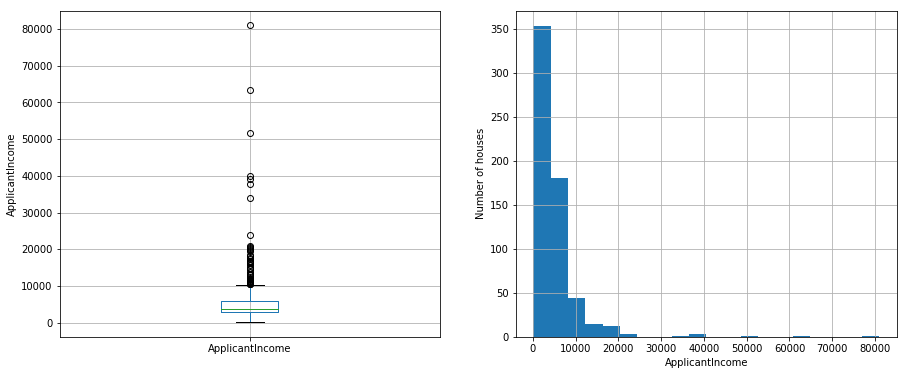

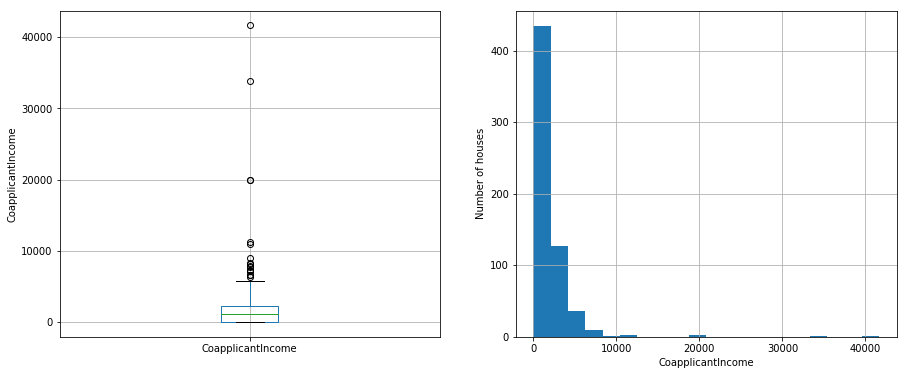

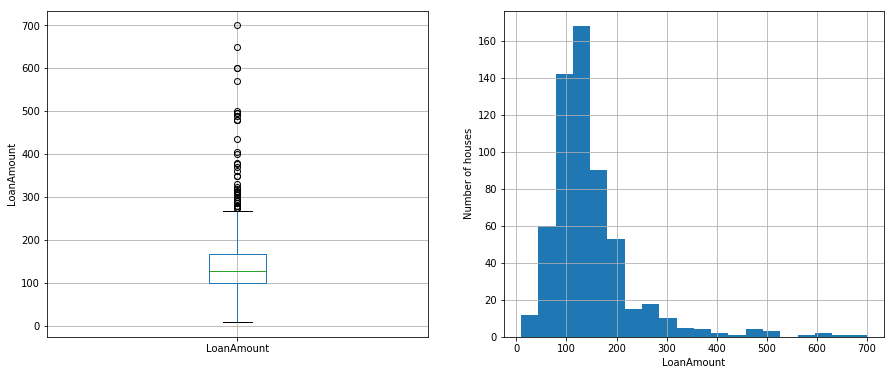

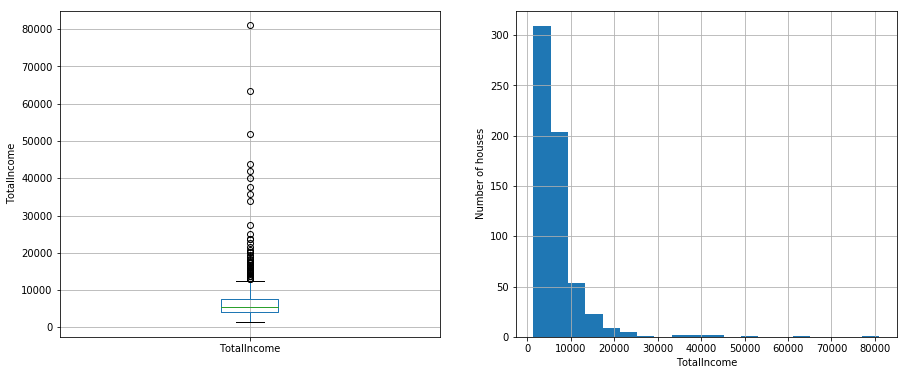

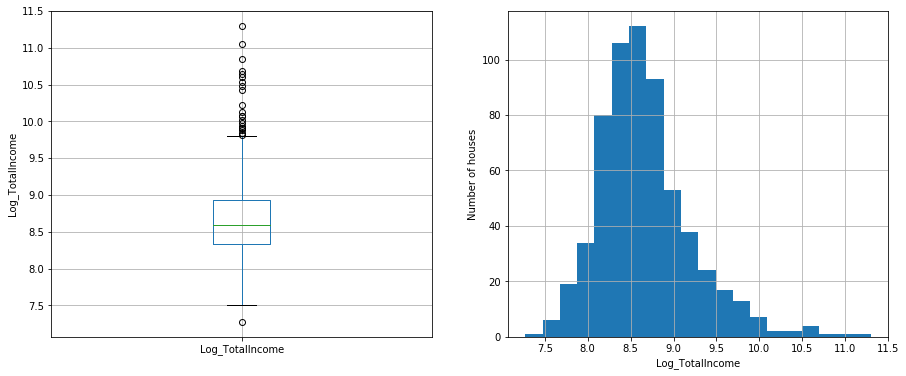

In [28]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize = (15,6))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column = var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins = 20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)
    
    plt.show()

### Outliers in discrete variables

In [29]:
for var in discrete:
    print( data[var].value_counts() / np.float(len(data)))
    print()

0.0    0.586319
1.0    0.166124
2.0    0.164495
3.0    0.083062
Name: Dependents, dtype: float64

360.0    0.833876
180.0    0.071661
480.0    0.024430
300.0    0.021173
84.0     0.006515
240.0    0.006515
120.0    0.004886
36.0     0.003257
60.0     0.003257
12.0     0.001629
Name: Loan_Amount_Term, dtype: float64

1.0    0.773616
0.0    0.144951
Name: Credit_History, dtype: float64

0    0.620521
1    0.379479
Name: Semiurban, dtype: float64

0    0.67101
1    0.32899
Name: Urban, dtype: float64

0    0.708469
1    0.291531
Name: Rural, dtype: float64



In [30]:
# print variables with missing data
for col in continuous:
    if data[col].isnull().mean() > 0:
        print(col, data[col].isnull().mean())

LoanAmount 0.035830618892508145


In [31]:
for df in [data_val,data]:
    for var in ['LoanAmount']:
        df[var+'_NA'] = np.where(df[var].isnull(),1,0)
        df[var].fillna(df[var].median(), inplace = True)

In [33]:
for col in discrete:
    if data[col].isnull().mean() > 0:
        print(col, data[col].isnull().mean())

Loan_Amount_Term 0.02280130293159609
Credit_History 0.08143322475570032


In [34]:
for df in [data_val,data]:
    for var in ['Loan_Amount_Term']:
        df[var+'_NA'] = np.where(df[var].isnull(),1,0)
        df[var].fillna(df[var].median(), inplace = True)

In [35]:
objects = ['Credit_History','Gender','Self_Employed','Married']

for df in [data_val,data]:
    for var in objects:
        df[var].fillna(df[var].mode()[0], inplace=True)

### Outliers in Numerical variables

In [36]:

IQR = data.ApplicantIncome.quantile(0.75) - data.ApplicantIncome.quantile(0.25)

Lower_fence = data.ApplicantIncome.quantile(0.25) - (IQR * 1.5)
Upper_fence = data.ApplicantIncome.quantile(0.75) + (IQR * 1.5)

Upper_fence, Lower_fence, IQR

(10171.25, -1498.75, 2917.5)

In [37]:
Upper_boundary = data.CoapplicantIncome.mean() + 1.5* data.CoapplicantIncome.std()
Lower_boundary = data.CoapplicantIncome.mean() - 1.5* data.CoapplicantIncome.std()

Upper_boundary, Lower_boundary

(6010.618351863384, -2768.126755809182)

In [38]:

IQR = data.LoanAmount.quantile(0.75) - data.LoanAmount.quantile(0.25)

Lower_fence = data.LoanAmount.quantile(0.25) - (IQR * 1.5)
Upper_fence = data.LoanAmount.quantile(0.75) + (IQR * 1.5)

Upper_fence, Lower_fence, IQR

(261.5, 3.5, 64.5)

In [39]:
data['TotalIncome']= data['ApplicantIncome']+data['CoapplicantIncome']
data_val['TotalIncome']=data_val['ApplicantIncome']+data_val['CoapplicantIncome']
#Take a log of TotalIncome + 1, adding 1 to deal with zeros of TotalIncome it it exists
data['Log_TotalIncome']=np.log(data['TotalIncome'])
data_val['Log_TotalIncome']=np.log(data_val['TotalIncome'])

In [40]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, top, df[variable])

for df in [X_train, X_test, data_val,data]:
    df['ApplicantIncome'] = top_code(df, 'ApplicantIncome', 14547)
    df['CoapplicantIncome'] = top_code(df, 'CoapplicantIncome', 6010)
    df['LoanAmount'] = top_code(df, 'LoanAmount', 270)

NameError: name 'X_train' is not defined

In [41]:
for df in [data,data_val]:
    for var in ['Gender','Married','Education','Self_Employed']:
        df[var] = pd.get_dummies(df[var], drop_first = True)
        


In [42]:
variables_that_need_scaling = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount', 'Dependents']

In [44]:
training_vars = [var for var in data.columns if var not in ['Loan_ID', 'Loan_Status']]

### Separate train and test set

In [45]:
#Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data, data.Loan_Status, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((491, 19), (123, 19))

In [46]:
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set and then transform it

MinMaxScaler(copy=True, feature_range=(0, 1))

In [47]:
xgb_model = xgb.XGBClassifier()

eval_set = [(X_test[training_vars], y_test)]
xgb_model.fit(X_train[training_vars], y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

pred = xgb_model.predict_proba(X_train[training_vars])
print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = xgb_model.predict_proba(X_test[training_vars])
print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

xgb train roc-auc: 0.9632776388573161
xgb test roc-auc: 0.7898989898989899


In [48]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train[training_vars], y_train)

pred = rf_model.predict_proba(X_train[training_vars])
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = rf_model.predict_proba(X_test[training_vars])
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

RF train roc-auc: 0.9994506327195575
RF test roc-auc: 0.7439393939393939


In [49]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train[training_vars], y_train)

pred = ada_model.predict_proba(X_train[training_vars])
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(X_test[training_vars])
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Adaboost train roc-auc: 0.9047226642418731
Adaboost test roc-auc: 0.7912457912457913


In [50]:
logit_model = LogisticRegression()
logit_model.fit(scaler.transform(X_train[training_vars]), y_train)

pred = logit_model.predict_proba(scaler.transform(X_train[training_vars]))
print('Logit train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(scaler.transform(X_test[training_vars]))
print('Logit test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Logit train roc-auc: 0.792225505796772
Logit test roc-auc: 0.7631313131313132


In [51]:
pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(X_test[training_vars])[:,1]))

final_pred = pd.concat(pred_ls, axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_pred)))

Ensemble test roc-auc: 0.7279461279461279


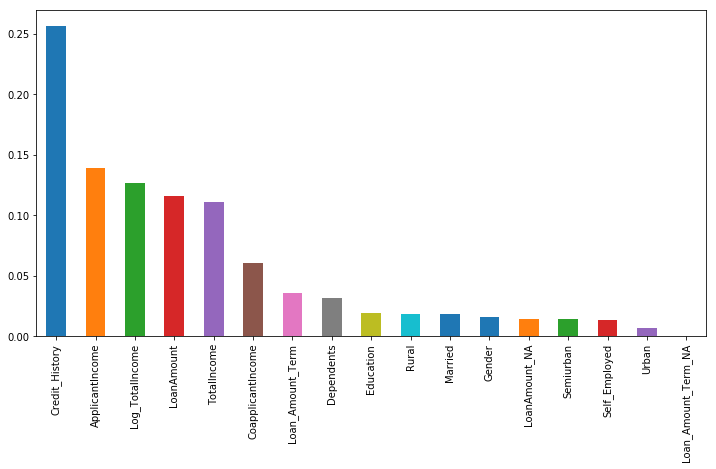

In [52]:
importance = pd.Series(rf_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

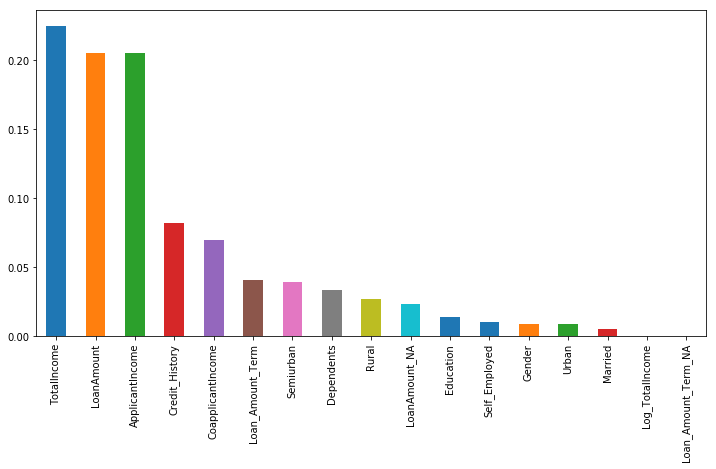

In [53]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

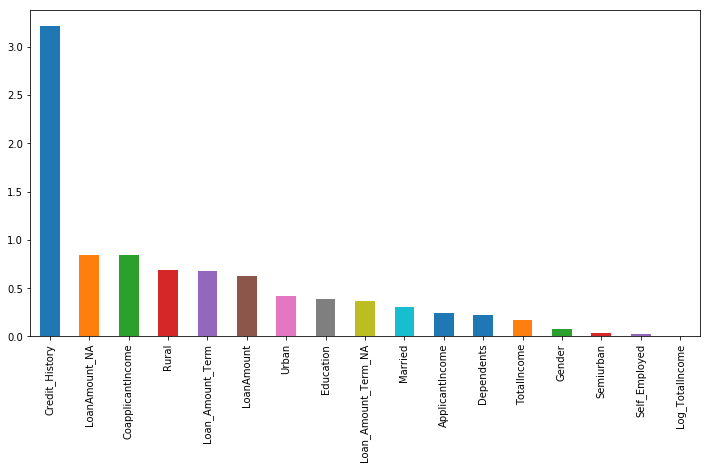

In [54]:
importance = pd.Series(np.abs(logit_model.coef_.ravel()))
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [56]:
pred = ada_model.predict(data_val[training_vars])
final = pd.DataFrame({'Loan_ID': data_val['Loan_ID'],
                     'Loan_Status': pred})
final.to_csv('loan-submission.csv',index = False)